# Semi-automatic KG Ontology for QM FAQ
- **Pre-processing steps to create JSON of triplets** [Diagram Given below]:
  - Summarize each section using the Prompt-V3_1.
  - Turned a 30-page PDF into 4-pages Summary PDF.
  - Highlighted some of the selected sentences from the Summary PDF.
  - Take each of the selected sentences from the Summary PDF and give the Prompt-V3_2.
  - Analyse manually to be consistent with the 4-step verification.
- **Python code to convert the JSON into Neo4j GraphDB**:
  - Neo4j Util Functions
  - Add triplets from JSON into Neo4j Graph DB

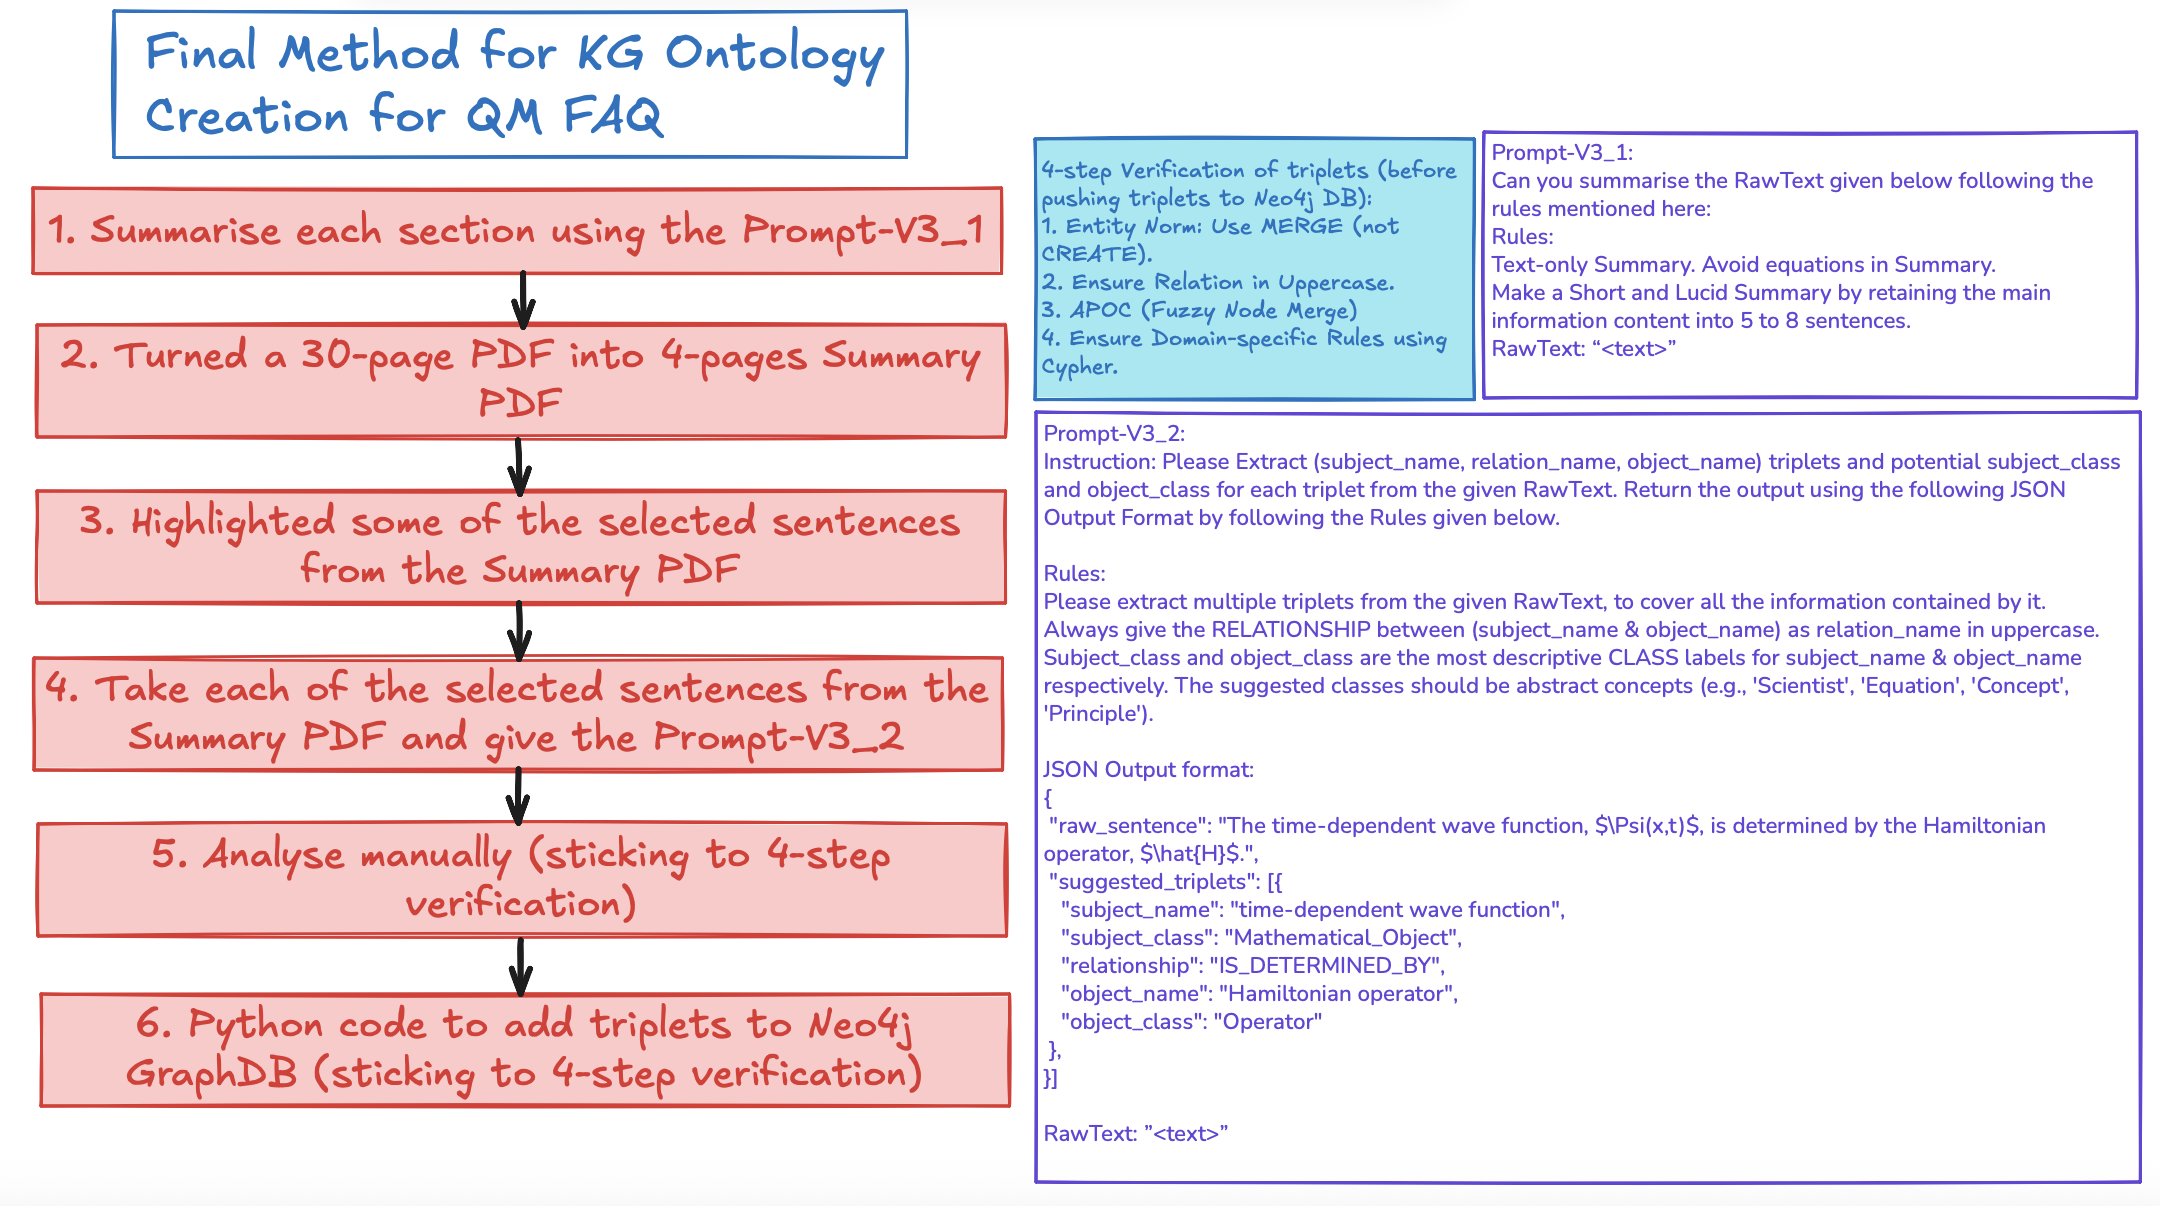

### Installation

In [ ]:
!pip install neo4j

### Imports

In [ ]:
import os
import json
from neo4j import GraphDatabase

### CONFIG

In [ ]:
DATA_PATH = ""

### Neo4j API Keys

In [ ]:
from google.colab import userdata, drive
NEO4J_URI = userdata.get('NEO4J_URI')
NEO4J_USERNAME = userdata.get('NEO4J_USERNAME')
NEO4J_PASSWORD = userdata.get('NEO4J_PASSWORD')
DATA_PATH = userdata.get("QM_DATA_PATH")

### Access Docs from Drive

In [ ]:
# --- Mount Google Drive ---
# This allows the script to access your PDF file from Google Drive.
import time
drive.mount('/content/drive')
print("Google Drive mounted successfully.")
time.sleep(10)

In [ ]:
import glob
qm_json_path_arr = glob.glob(os.path.join(DATA_PATH, "*.json"))
print(qm_json_path_arr)
json_path = qm_json_path_arr[0]

In [ ]:
with open(json_path, 'r') as file:
    data = json.load(file)
print(data)

In [ ]:
# print(data["all_triplets_by_sent"][0])

print(data["all_triplets_by_sent"][40])
no_triplets = len(data["all_triplets_by_sent"])
print(no_triplets)
for i in range(no_triplets):
    raw_sent = data["all_triplets_by_sent"][i]["raw_sentence"]
    no_triplets_per_sent = len(data["all_triplets_by_sent"][i]["suggested_triplets"])
    print(f"RAW_SENT: {raw_sent}")
    print(f"NO_TRIPETS IN RAW_SENT: {no_triplets_per_sent}")

### Neo4j Util Functions

In [ ]:
def get_neo4j_credentials():
    return NEO4J_URI, NEO4J_USERNAME, NEO4J_PASSWORD

## Funttion to get Neo4j DB driver
def get_driver():
    """Creates a Neo4j driver instance."""
    uri, user, password = get_neo4j_credentials()
    return GraphDatabase.driver(uri, auth=(user, password), max_connection_lifetime=3600)

### Add triplets from JSON to Neo4j Dataset

In [ ]:
driver = get_driver()
print(data["all_triplets_by_sent"][40])
no_triplets = len(data["all_triplets_by_sent"])
print(no_triplets)

In [ ]:
# Delete the previously exiting Neo4j DB
relation_delete_query = "MATCH ()-[r]->() DELETE r;"
node_delete_query = "MATCH (n) DETACH DELETE n;"
# query = f"{relation_delete_query} {node_delete_query}"
with driver.session() as session:
    session.run(relation_delete_query)
with driver.session() as session:
    session.run(node_delete_query)

In [ ]:
# Add triplets from JSON to Neo4j
for i in range(no_triplets):
    raw_sent = data["all_triplets_by_sent"][i]["raw_sentence"]
    no_triplets_per_sent = len(data["all_triplets_by_sent"][i]["suggested_triplets"])
    triplet_arr_per_sent = data["all_triplets_by_sent"][i]["suggested_triplets"]
    print(f"RAW_SENT: {raw_sent}")
    for triplet in triplet_arr_per_sent:
        subject_class = triplet["subject_class"]
        subject_name = triplet["subject_name"]
        object_class = triplet["object_class"]
        object_name = triplet["subject_class"]
        relation = triplet["relationship"]

        print(f"subject_class = {subject_class}")
        print(f"subject_name = {subject_name}")
        print(f"object_class = {object_class}")
        print(f"object_name = {object_name}")
        print(f"relation = {relation}")

        # Check & Pass if Relation name is all Caital Letters [convert to UPPERCASE]
        # Check & Pass if Subjec class and Object class does not contain any space [replace space with underscore]

        query = f"""
        MERGE (s:{subject_class} {{name: $subj_name}})
        MERGE (o:{object_class} {{name: $obj_name}})
        MERGE (s)-[r:{relation}]->(o)
        RETURN s, r, o
        """
        # These are the values safely passed to Neo4j
        parameters = {
            "subj_name": subject_name,
            "obj_name": object_name
        }
        with driver.session() as session:
            result = session.run(query, **parameters)
            print("Successfully created triplet:")
            for record in result:
                print(f"({record['s']['name']})-[:{relation}]->({record['o']['name']})")

    print(f"Added {no_triplets_per_sent} triplets to Neo4j")
    print("=======================================================")

### The Resulting KG has the following Issues => Post-processing steps:
**Issues**:
1. For few node pairs (not many) there are multiple relations between the same pair of nodes.
2. There are many small disconnected components that comprise the graph.

Issue (1) can be a feature also sometimes, but we need to check it thoroughly if it is noise. Issue (2) is a serious issue for multi-hop queries. Practical post-processing steps to take here:

**Remedies**:
1. Node Normalization: Check if multiple different nodes mean the same thing.
2. Hub-node: For all non-reachable nodes add a chapter node “Spin and Entanglement” and domain node “Quantum Mechanics”.
MATCH (n)
WHERE NOT (n)<-[]-()
RETURN n
3. Super-relation: Re-run a LLM inference pass focused only on extracting the highly-connecting IS_A and PART_OF relations.

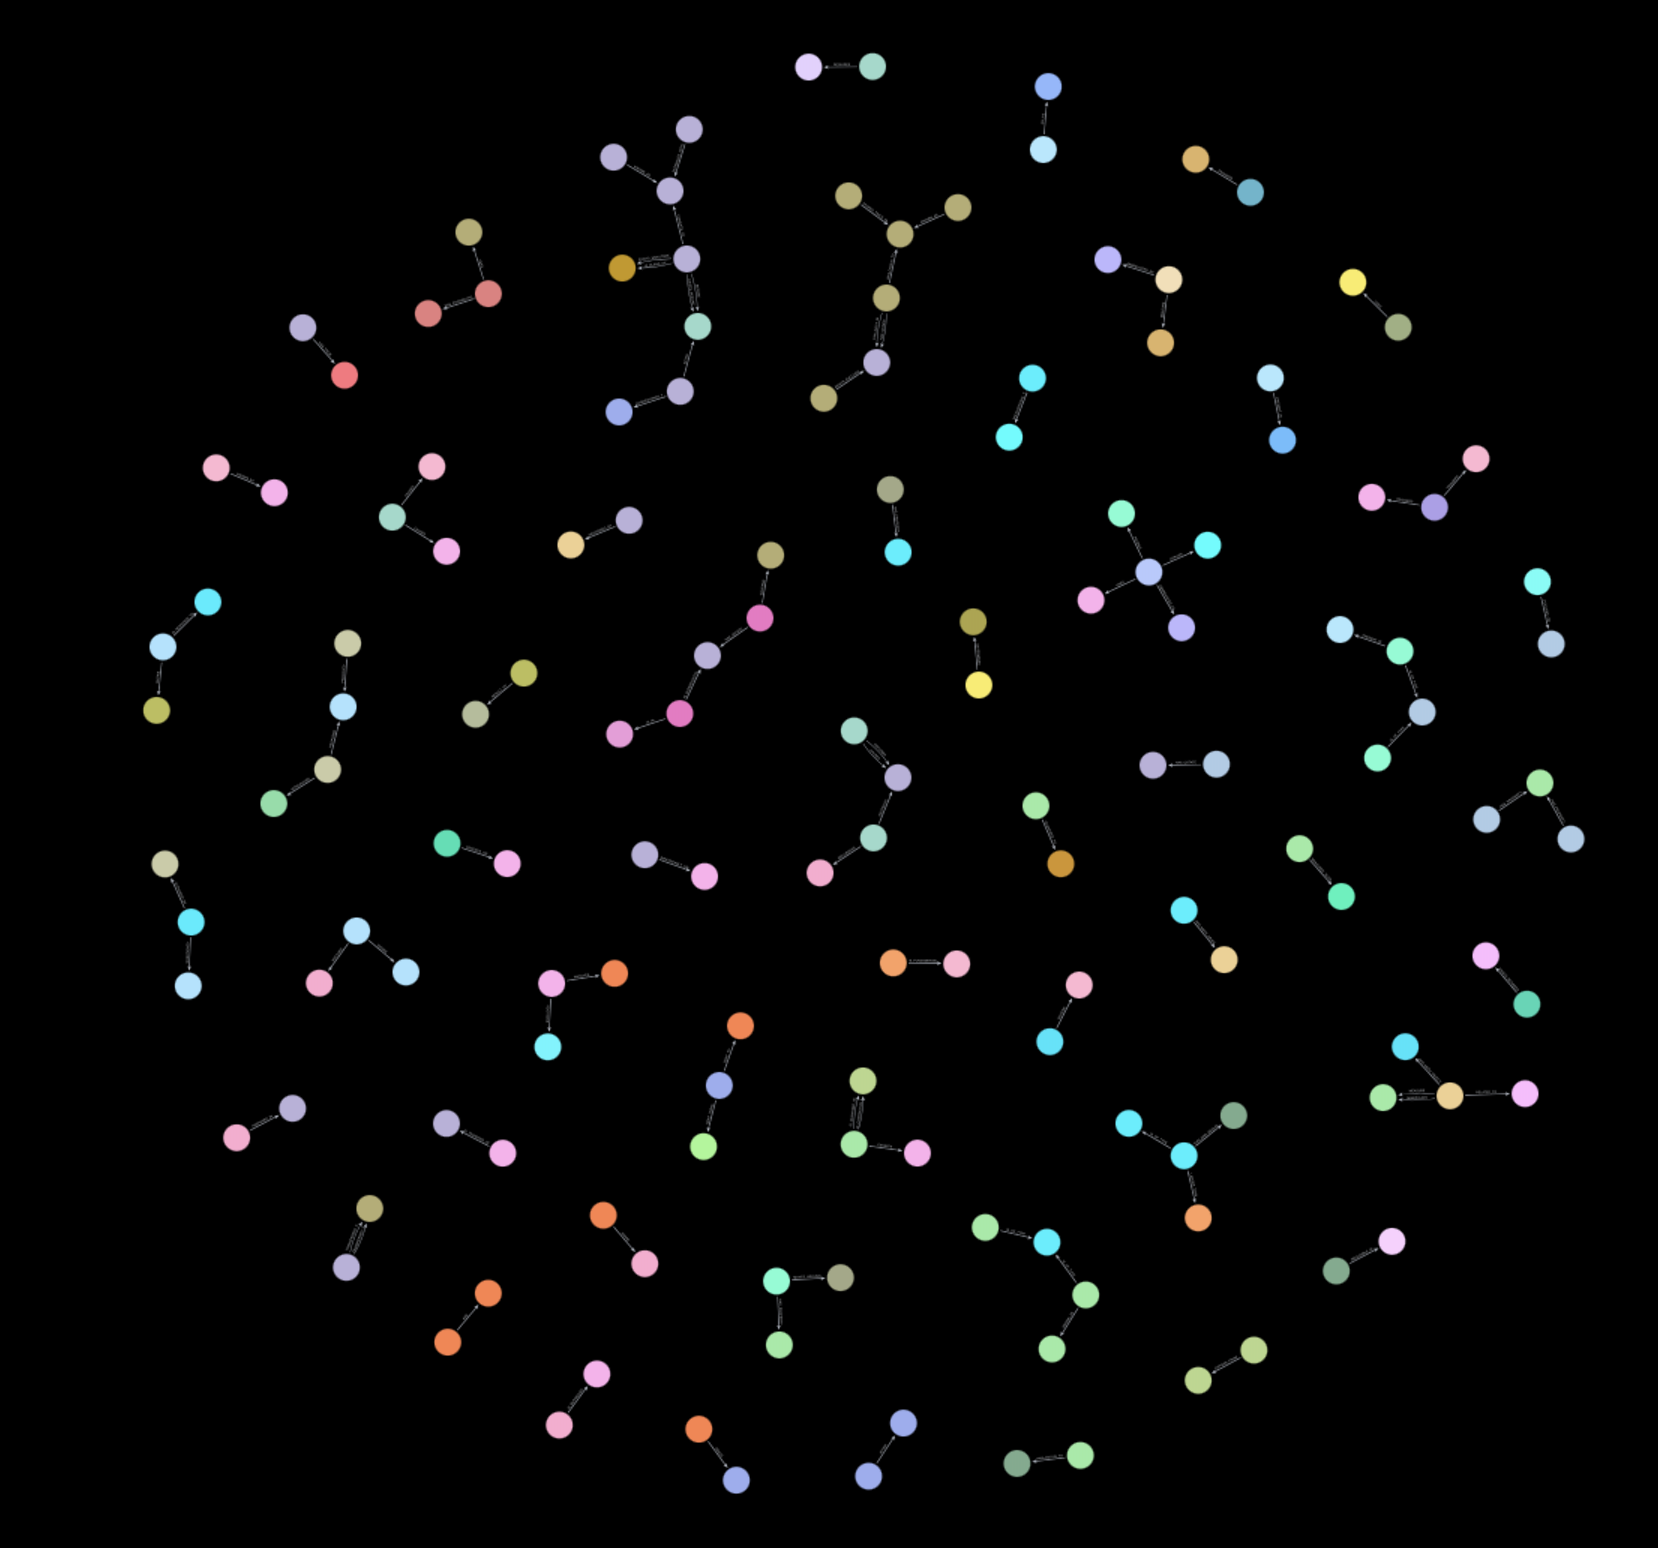

In [ ]:
## Create Chapter and Domain Nodes
hub_node_query = f"""MERGE (c:Chapter {{name: 'Spin Entanglement'}})
MERGE (d:Domain {{name: 'Quantum_Mechanics'}})
MERGE (c)-[:IS_PART_OF]->(d)
"""
with driver.session() as session:
    result = session.run(hub_node_query)

In [ ]:
## Find the disconnected Nodes in Neo4j DB
disconnected_node_query = "MATCH (n) WHERE NOT (n)<-[]-() RETURN n;"
discon_node_arr = []

with driver.session() as session:
    result = session.run(disconnected_node_query)
    for record in result:
        node_class = list(record['n'].labels)[0]
        node_name = dict(record['n'])['name']
        print(f"node_class = {node_class}, node_name = {node_name}")
        discon_node_arr.append({"class": node_class, "name": node_name})
        # print(f"({node_class}), ({node_name})")

In [ ]:
print(len(discon_node_arr))
print(discon_node_arr[0])

In [ ]:
## All Nodes as Concept BELONGS_TO_CHAPTER
for node in discon_node_arr:
    with driver.session() as session:
        node_class = node["class"]
        node_name = node["name"]
        hub_rel_query = f"""MERGE (c:Chapter {{name: 'Spin Entanglement'}})
        MERGE (n:{node_class} {{name: $node_name}})
        MERGE (n)-[:BELONGS_TO_CHAPTER]->(c)
        """
        session.run(hub_rel_query, node_name=node_name)

### KG after Post-processing

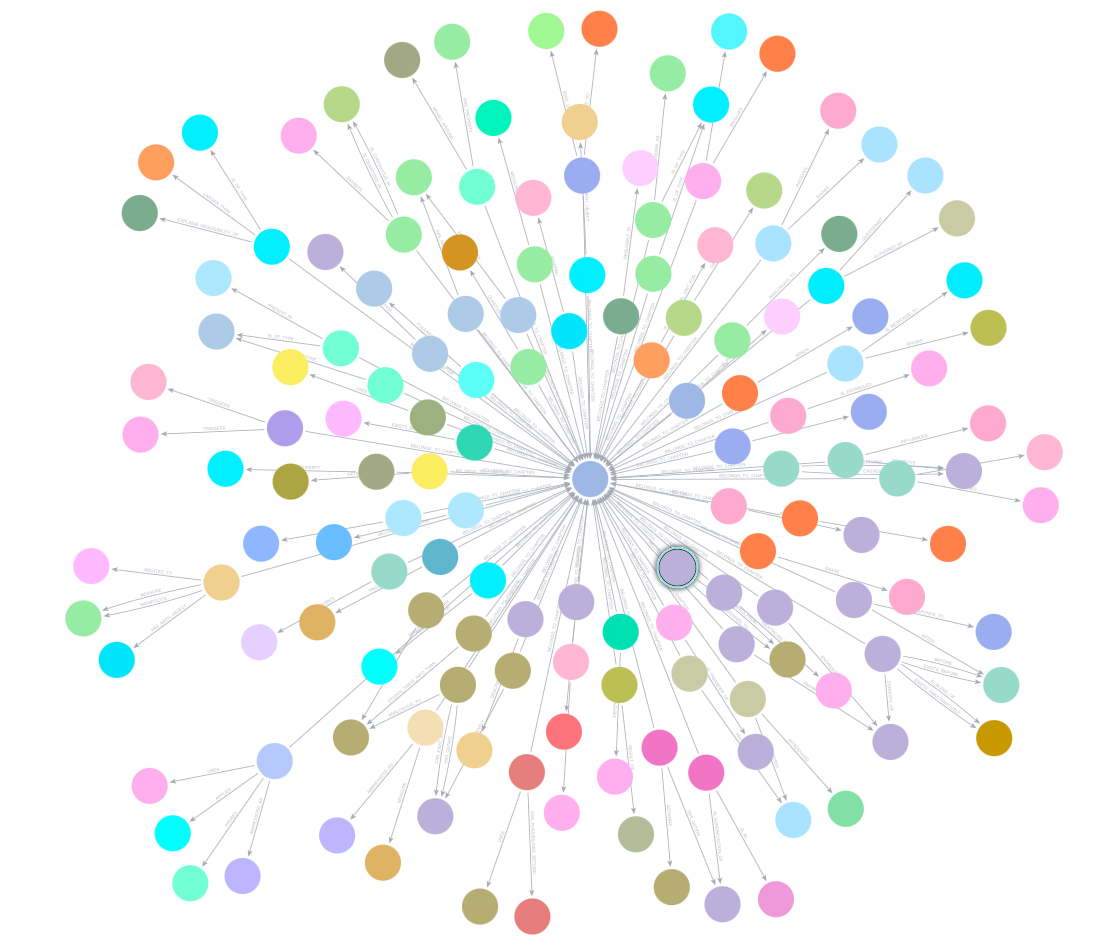